# Proyecto de pruebas A/B: Prueba recommender_system_test

# Índice del Proyecto

| Sección                       | Descripción                                                       |
|-------------------------------|-------------------------------------------------------------------|
| 1. [Introducción](#introducción)          | Breve descripción del proyecto y sus objetivos.                |
| 2. [Preprocesamiento de Datos](#Análisis)|Importación de librerías, carga de datos, revisión de duplicados, nulos y tipo de datos.   |
| 3. [Análisis Datos](#instalación)         |Análisis de cohorte y métricas.|
| 4. [Prueba de hipótesis](#resultados)     |Prueba de hipótesis test A/B.          |
| 5. [Conclusiones](#conclusiones)          |Resumen de las conclusiones .       |


# Introducción

En el presente proyecto se cuenta con especificaciones técnicas y los resultados una prueba A/B realizada anteriormente, con ello se verificará si se ha realizado correctamente y se analizará los resultados.

## Descripción Técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión
 en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) 
 y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

# Preprocesamiento de Datos

## Importación de librerías

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, norm
import math

## Carga de datos

In [150]:
Calendario_Event = pd.read_csv("ab_project_marketing_events_us.txt")
data_users = pd.read_csv("final_ab_new_users_upd_us.txt")
data_eventos = pd.read_csv("final_ab_events_upd_us.txt")
data_prueba = pd.read_csv("final_ab_participants_upd_us.txt")

In [151]:
Calendario_Event.sample(10)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07


In [152]:
data_users.sample(5)

,user_id,first_date,region,device
1937,645F4EE1FDC99C91,2020-12-07,EU,PC
24087,7E6545620AE5DC37,2020-12-22,EU,Android
16510,8D818A010082D32D,2020-12-21,EU,Mac
50550,275C7EF67C629D2E,2020-12-13,EU,Mac
32565,A74D5A3C20AAAF6F,2020-12-10,EU,Android


In [153]:
data_eventos.sample(5)

,user_id,event_dt,event_name,details
209786,D033CF0A6DE7E0AC,2020-12-22 06:55:03,product_page,NaN
135022,1B93EAC69E03A6C2,2020-12-11 05:20:07,product_page,NaN
396541,FC93A77E4F5D5E0F,2020-12-24 02:05:07,login,NaN
315474,A49A47DB64E786EF,2020-12-16 14:37:27,login,NaN
231984,C44827B9BF9D3134,2020-12-27 20:43:00,product_page,NaN


In [154]:
data_prueba.sample(5)

,user_id,group,ab_test
10978,984B7ED8DE0A4159,B,interface_eu_test
9087,93D76FD0A17370A5,B,interface_eu_test
13680,7AC55CA05DC53582,A,interface_eu_test
6250,DCFD32B9F3958615,A,interface_eu_test
3368,9B3DEB6615CFFE54,B,recommender_system_test


## Comprobando tipos de datos 

In [155]:
Calendario_Event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [156]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [157]:
data_eventos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [158]:

data_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


### Convirtiendo tipos de datos


In [159]:

data_eventos["event_name"].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [160]:

data_users["device"].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [161]:
# Convirtiendo a tipo de datos datatime

Calendario_Event["start_dt"] = pd.to_datetime(
    Calendario_Event["start_dt"], format='%Y-%m-%d')  # convirtiendo a datatime

Calendario_Event["finish_dt"] = pd.to_datetime(
    # convirtiendo a datatime
    Calendario_Event["finish_dt"], format='%Y-%m-%d')

In [162]:
# Convirtiendo a tipo de datos datatime

data_users["first_date"] = pd.to_datetime(
    data_users["first_date"], format='%Y-%m-%d')  # convirtiendo a datatime
# Convirtiendo a tipo de datos datatime

data_eventos["fecha_hora"] = pd.to_datetime(
    data_eventos["event_dt"])  # convirtiendo a datatime
data_eventos["fecha"] = data_eventos["fecha_hora"].dt.date  # extrayendo fecha


# Convirtiendo los eventos a tipo de datos categoricos

data_eventos["event_name"] = data_eventos["event_name"].astype("category")

# Convirtiendo las fuentes a tipo de datos categoricos

data_users["device"] = data_users["device"].astype("category")

## Comprobando valores duplicados

In [163]:
print(Calendario_Event.duplicated().sum())
print(data_users.duplicated().sum())
print(data_eventos.duplicated().sum())
print(data_prueba.duplicated().sum())

0
0


0
0


Usuarios únicos en los registros

In [164]:

print(data_users.nunique())


user_id       58703
first_date       17
region            4
device            4
dtype: int64


No hay filas duplicadas en los datasets.

## Comprobando valores valores ausentes

In [165]:

print(data_eventos.isnull().sum())

#data_eventos=data_eventos.drop("details", axis=1) # Borrando columna detalles ya que contiene muchos valores nulos

user_id            0
event_dt           0
event_name         0
details       363447
fecha_hora         0
fecha              0
dtype: int64


# Análisis de Datos

## Filtrando usuarios de la region UE

In [166]:
data_users = data_users[data_users["region"] == "EU"]

## Periodo de tiempo de los datos

In [167]:
print(data_eventos["fecha_hora"].min())
print(data_eventos["fecha_hora"].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Los datos cubren desde 07/12/2020 al 30/12/2020

## Usuarios en la prueba A/B

## Filtrando usuarios que participaron en un solo test " recommender_system_test "

In [168]:
data_prueba["user_id"].drop_duplicates()

data_prueba = data_prueba[data_prueba["ab_test"] == "recommender_system_test"]

In [169]:
# Uniendo tablas

data_new = data_eventos.merge(data_users, on="user_id")

data_new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314777 entries, 0 to 314776
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     314777 non-null  object        
 1   event_dt    314777 non-null  object        
 2   event_name  314777 non-null  category      
 3   details     46687 non-null   float64       
 4   fecha_hora  314777 non-null  datetime64[ns]
 5   fecha       314777 non-null  object        
 6   first_date  314777 non-null  datetime64[ns]
 7   region      314777 non-null  object        
 8   device      314777 non-null  category      
dtypes: category(2), datetime64[ns](2), float64(1), object(4)
memory usage: 17.4+ MB


In [170]:
data_prueba.groupby("group")["user_id"].count()


data_new = data_new.merge(data_prueba, on="user_id")

## Filtrando usuarios que estuvieron menos de 14 días

In [171]:
data_new["days"] = pd.to_datetime(
    data_new['event_dt']) - pd.to_datetime(data_new['first_date'])

data_new = data_new[data_new['days'].dt.days < 14]

## Distribución de eventos en el tiempo

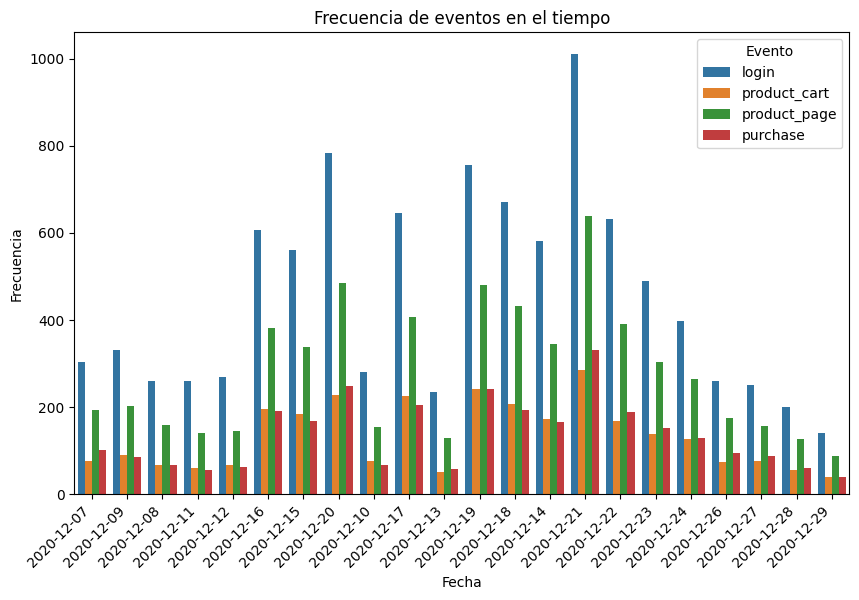

In [172]:
# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Graficar el countplot con el parámetro hue
sns.countplot(x='fecha', hue='event_name', data=data_new)

# Agregar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de eventos en el tiempo')

# Rotar las etiquetas del eje X para mejorar la legibilidad
plt.xticks(rotation=45, ha="right")

plt.legend(title='Evento')  # Agregar leyenda

plt.show()

La distribución de los eventos se muestran uniformes a los largo de los días

## Conversión en las etapas del embudo

In [173]:
display(data_new)

,user_id,event_dt,event_name,details,fecha_hora,fecha,first_date,region,device,group,ab_test,days
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07 06:50:29,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09 02:19:17,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07 06:50:30,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:30
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08 10:52:27,2020-12-08,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:27
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09 02:19:17,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17
...,...,...,...,...,...,...,...,...,...,...,...,...
22669,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,2020-12-27 10:53:34,2020-12-27,2020-12-21,EU,PC,A,recommender_system_test,6 days 10:53:34
22670,BEF16764A13AEC34,2020-12-21 03:49:49,login,NaN,2020-12-21 03:49:49,2020-12-21,2020-12-21,EU,PC,B,recommender_system_test,0 days 03:49:49
22671,BEF16764A13AEC34,2020-12-22 18:52:25,login,NaN,2020-12-22 18:52:25,2020-12-22,2020-12-21,EU,PC,B,recommender_system_test,1 days 18:52:25
22672,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,2020-12-24 22:11:00,2020-12-24,2020-12-21,EU,PC,B,recommender_system_test,3 days 22:11:00


In [174]:
# Creando columna con el primer evento de cada nuevo usuario

min_event_datetime = data_new.groupby(['user_id'])['fecha_hora'].min()

min_event_datetime.name = 'min_event_datetime'

# Agregando columna con el primer evento de cada usuario

data_new= data_new.join(min_event_datetime, on='user_id')

In [175]:
data_new

,user_id,event_dt,event_name,details,fecha_hora,fecha,first_date,region,device,group,ab_test,days,min_event_datetime
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07 06:50:29,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:29,2020-12-07 06:50:29
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-09 02:19:17,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17,2020-12-07 06:50:29
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,2020-12-07 06:50:30,2020-12-07,2020-12-07,EU,Android,A,recommender_system_test,0 days 06:50:30,2020-12-07 06:50:29
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,2020-12-08 10:52:27,2020-12-08,2020-12-07,EU,Android,A,recommender_system_test,1 days 10:52:27,2020-12-07 06:50:29
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,2020-12-09 02:19:17,2020-12-09,2020-12-07,EU,Android,A,recommender_system_test,2 days 02:19:17,2020-12-07 06:50:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22669,1484BBF124DB1B18,2020-12-27 10:53:34,login,NaN,2020-12-27 10:53:34,2020-12-27,2020-12-21,EU,PC,A,recommender_system_test,6 days 10:53:34,2020-12-21 17:51:44
22670,BEF16764A13AEC34,2020-12-21 03:49:49,login,NaN,2020-12-21 03:49:49,2020-12-21,2020-12-21,EU,PC,B,recommender_system_test,0 days 03:49:49,2020-12-21 03:49:49
22671,BEF16764A13AEC34,2020-12-22 18:52:25,login,NaN,2020-12-22 18:52:25,2020-12-22,2020-12-21,EU,PC,B,recommender_system_test,1 days 18:52:25,2020-12-21 03:49:49
22672,BEF16764A13AEC34,2020-12-24 22:11:00,login,NaN,2020-12-24 22:11:00,2020-12-24,2020-12-21,EU,PC,B,recommender_system_test,3 days 22:11:00,2020-12-21 03:49:49


In [176]:
Calendario_Event

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Estudiar el embudo de eventos


In [177]:

data_new.groupby("event_name")["user_id"].count(
).sort_values(ascending=False).reset_index()

C:\Users\LUCIA\AppData\Local\Temp\ipykernel_13600\268732816.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_new.groupby("event_name")["user_id"].count(


,event_name,user_id
0,login,9919
1,product_page,6132
2,purchase,2998
3,product_cart,2903


## Histograma por fecha y hora

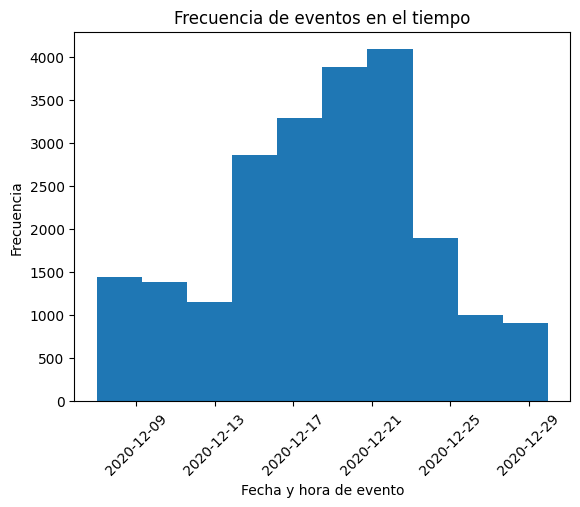

In [178]:
plt.hist(data_new["fecha_hora"])

# Agregar etiquetas y título
plt.xlabel('Fecha y hora de evento')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de eventos en el tiempo')
plt.xticks(rotation=45)

plt.show()

## Cantidad de usuarios por evento

In [179]:
data_resumen = data_new .groupby("event_name")["user_id"].nunique(
).sort_values(ascending=False).reset_index()
display(data_resumen)

C:\Users\LUCIA\AppData\Local\Temp\ipykernel_13600\2534558857.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_resumen = data_new .groupby("event_name")["user_id"].nunique(


,event_name,user_id
0,login,3480
1,product_page,2178
2,purchase,1082
3,product_cart,1026


In [180]:
#Calculando embudo

data_resumen["n_id_prev"] = data_resumen["user_id"].shift(1)
data_resumen["variación"] = data_resumen["user_id"] / data_resumen["n_id_prev"]

data_resumen["conversion"] = data_resumen["user_id"] / data_resumen["n_id_prev"]
data_resumen["ratio"] = 1 - data_resumen["conversion"]

display(data_resumen)

,event_name,user_id,n_id_prev,variación,conversion,ratio
0,login,3480,NaN,NaN,NaN,NaN
1,product_page,2178,3480.0,0.625862,0.625862,0.374138
2,purchase,1082,2178.0,0.496786,0.496786,0.503214
3,product_cart,1026,1082.0,0.948244,0.948244,0.051756


# Prueba de hipótesis

In [189]:


# Función prueba de significancia para dos grupos con cálculo de z-score
def t_test_with_zscore(df, group1, group2, event, group_col="group"):
    conversions = df[["user_id", group_col]].drop_duplicates()

    converted = pd.DataFrame(data={
        "user_id": df[df["event_name"] == event]["user_id"].unique(),
        "converted": 1
    })

    conversions = conversions.merge(converted, on="user_id", how="left")
    conversions["converted"] = conversions["converted"].fillna(0)

    # Prueba t
    statistic, pvalue = ttest_ind(
        conversions[conversions[group_col] == group1]["converted"],
        conversions[conversions[group_col] == group2]["converted"]
    )

    # Cálculo del z-score
    n1 = conversions[conversions[group_col] == group1].shape[0]
    n2 = conversions[conversions[group_col] == group2].shape[0]
    x1 = conversions[conversions[group_col] == group1]["converted"].sum()
    x2 = conversions[conversions[group_col] == group2]["converted"].sum()
    p1 = x1 / n1
    p2 = x2 / n2
    p_combined = (x1 + x2) / (n1 + n2)

    z_score = (p1 - p2) / \
        ((p_combined * (1 - p_combined) * (1/n1 + 1/n2)) ** 0.5)
    p_value_z = norm.sf(abs(z_score)) * 2  # Prueba de dos colas

    result = {
        "t_statistic": statistic,
        "t_pvalue": pvalue,
        "z_score": z_score,
        "z_pvalue": p_value_z,
       
    }

    return result

In [190]:
events = data_new["event_name"].unique()
print("Running A/B tests...")
for event in events:
    result = t_test_with_zscore(data_new, "A", "B", event)
    print(result)

Running A/B tests...
{'t_statistic': 1.9911621632269447, 't_pvalue': 0.04654114479380872, 'z_score': 1.9906004806163913, 'z_pvalue': 0.04652482738393029}
{'t_statistic': 1.2406846609642443, 't_pvalue': 0.21480592200940893, 'z_score': 1.2407667698576503, 'z_pvalue': 0.21469192029582396}
{'t_statistic': 1.7236283932805712, 't_pvalue': 0.08486379476472086, 'z_score': 1.7233880726932327, 'z_pvalue': 0.08481837035887359}
{'t_statistic': 4.507247296872992, 't_pvalue': 6.7836918039713375e-06, 'z_score': 4.495436444894488, 'z_pvalue': 6.94273935952599e-06}


C:\Users\LUCIA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [191]:
n_pruebas = 4
alpha = 0.05

print(f"""
Nivel de significancia para cada prueba debe ser mayor a : {1 - math.pow((1 - alpha), 1/n_pruebas)}
""")


Nivel de significancia para cada prueba debe ser mayor a : 0.012741455098566168



Primer resultado:

tanto la prueba t como el z-score rechazan la hipótesis nula con p-valores de aproximadamente 0.0465. Esto indica que hay una diferencia estadísticamente significativa entre los dos grupos para este evento.

2do resultado
 Tanto la prueba t como el z-score no rechazan la hipótesis nula con p-valores de aproximadamente 0.2148 y 0.2147, respectivamente. Esto indica que no hay una diferencia estadísticamente significativa entre los dos grupos para este evento.

3er resultado
Tanto la prueba t como el z-score no rechazan la hipótesis nula con p-valores de aproximadamente 0.0849 y 0.0848, respectivamente. Aunque los p-valores son menores a 0.1, no alcanzan el umbral comúnmente usado de 0.05, por lo que no hay una diferencia estadísticamente significativa entre los dos grupos para este evento, aunque hay una indicación de que podría haber una diferencia.

4to resultado

Tanto la prueba t como el z-score rechazan fuertemente la hipótesis nula con p-valores extremadamente bajos (aproximadamente 0.000006). Esto indica que hay una diferencia altamente significativa entre los dos grupos para este evento.


En el primer y cuarto eventos, tanto la prueba t como el z-score indican diferencias significativas entre los grupos.
En el segundo evento, no hay evidencia de una diferencia significativa entre los grupos.
En el tercer evento, aunque los p-valores son relativamente bajos, no alcanzan el umbral comúnmente usado de 0.05, por lo que no se considera una diferencia significativa.

El evento más importante es el de "purchase" y no hubo cambio significativo.



No se puede rechazar la hipotesis nula, lo que podemos concluir que no hay una diferencia estadísticamente significativa entre las muestras

# Conclusiones

En este caso, no hay evidencia suficiente para rechazar la hipótesis nula de que no hay diferencia entre los grupos A y B. Por lo tanto, se concluye que los grupos A y B son similares y que cualquier diferencia observada entre ellos podría deberse al azar en lugar de a un efecto real.

El recommender_system no genera cambios significativos en el comportamiento del usuario.

Solo el 33% de usuarios ven  product_page, luego de ver la pantalla de inicio.Esto puede sugerir indagar cuál es el motivo que hace que sea la etapa donde se pierda la mayor cantidad de usuarios. 